In [161]:
#imports and call stored df
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


%store -r cb_df_final
%store -r foursquare_df_final
%store -r yelp_df_final

Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [224]:
#combine individually with cb
cb_foursquare = cb_df_final.merge(foursquare_df_final, how='inner', left_on=['latitude', 'longitude'], right_on=['latitude', 'longitude'])
cb_yelp = cb_df_final.merge(yelp_df_final, how='inner', left_on=['latitude', 'longitude'], right_on=['latitude', 'longitude'])

combined_df_final = pd.concat([cb_foursquare, cb_yelp], ignore_index=False)


#drop these columns because not common and will be difficult to replace NaN with appropriate numbers and not common among API's
combined_df_final = combined_df_final.drop(columns=['popularity', 'total_photos', 'total_tips'])
combined_df_final



,latitude,longitude,free_bikes,distance,name,price,rating,address,total_ratings
0,49.262487,-123.114397,8.0,96.000000,Marulilu Cafe,2.0,8.2,"451W Broadway W (at Cambie St), Vancouver BC V...",112.0
1,49.262487,-123.114397,8.0,299.000000,Aperture Coffee Bar,1.0,8.7,"243 West Broadway (at Alberta St), Vancouver B...",94.0
2,49.262487,-123.114397,8.0,336.000000,Caffe Cittadella,2.0,8.6,"2310 Ash St (at W 7th Ave), Vancouver BC V5Z 3C2",81.0
3,49.262487,-123.114397,8.0,430.000000,Milano Coffee,2.0,9.0,"156 8th Ave W (btwn Columbia & Manitoba St), V...",121.0
4,49.262487,-123.114397,8.0,250.000000,Rogue Kitchen & Wetbar,3.0,8.3,"602W Broadway W (at Ash St), Vancouver BC V5Z 1G1",127.0
...,...,...,...,...,...,...,...,...,...
3816,49.270783,-123.141564,18.0,541.171382,Novo Italian,2.0,8.0,"2118 Burrard Street, Vancouver, BC V6J 3H6, Ca...",156.0
3817,49.270783,-123.141564,18.0,589.139556,Charqui,2.0,5.0,"1955 Cornwall Avenue, Vancouver, BC V6J 1C9, C...",50.0
3818,49.270783,-123.141564,18.0,514.785326,Grapes & Soda,2.0,9.0,"1541 W 6th Avenue, Vancouver, BC V6J 1R1, Canada",44.0
3819,49.270783,-123.141564,18.0,1087.141065,Maxine's Cafe & Bar,2.0,8.0,"1325 Burrard Street, Vancouver, BC V6Z 2B7, Ca...",77.0


Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

In [ ]:
#checking types
#combined_df_final.dtypes

for key in combined_df_final.keys():
    print(combined_df_final[key].isnull())

#combined_df_final['free_bikes'].isnull()

#change Data types
#column_names = ['free_bikes', 'distance', 'price', 'rating', 'total_ratings']
#for name in column_names:
#    combined_df_final[name].astype(int)

#check
#combined_df_final.head()

In [225]:
#check for duplicates
combined_df_final.shape

(6240, 9)

In [226]:
duplicate_rows = combined_df_final[combined_df_final.duplicated()]
print("number of duplicate rows:", duplicate_rows.shape)

number of duplicate rows: (0, 9)


In [227]:
combined_df_final.describe()
# I have some 0 values...will do further analysis below to see quantity before determining approach

,latitude,longitude,free_bikes,distance,price,rating,total_ratings
count,6240.000000,6240.000000,6240.000000,6240.000000,5269.000000,6223.000000,6223.000000
mean,49.272758,-123.116406,7.889103,560.222514,2.006643,8.005656,192.858107
std,0.011007,0.025881,5.240020,297.235209,0.656543,0.894167,216.842851
min,49.238105,-123.191458,0.000000,0.000000,1.000000,4.000000,0.000000
25%,49.264251,-123.132778,4.000000,329.041201,2.000000,7.900000,48.000000
50%,49.273103,-123.116963,7.000000,533.993635,2.000000,8.000000,119.000000
75%,49.281170,-123.100324,11.000000,787.409582,2.000000,8.700000,267.000000
max,49.302577,-123.035969,29.000000,1388.594226,4.000000,10.000000,2592.000000


In [236]:
# I see that my max distance is well over the 1000m radius limit, I will remove these because I am only interested for 1000m and less
combined_df_final = combined_df_final.drop(combined_df_final[combined_df_final['distance'] > 1000].index)



In [237]:
#check to see if values match
combined_df_final.describe()

,latitude,longitude,free_bikes,distance,price,rating,total_ratings
count,5456.000000,5456.000000,5456.000000,5456.000000,4608.000000,5440.000000,5440.000000
mean,49.272988,-123.116463,7.905609,514.728175,2.006076,7.994614,192.051838
std,0.011008,0.025739,5.207348,257.380138,0.659181,0.899618,215.161401
min,49.238105,-123.191458,0.000000,0.000000,1.000000,4.000000,0.000000
25%,49.264466,-123.132677,4.000000,314.000000,2.000000,7.900000,48.000000
50%,49.273568,-123.116963,7.000000,502.910797,2.000000,8.000000,120.000000
75%,49.281506,-123.100792,11.000000,713.638349,2.000000,8.700000,266.000000
max,49.302577,-123.035969,29.000000,999.561524,4.000000,10.000000,2592.000000


In [213]:
combined_df_final.count()
print(combined_df_final.isnull().sum())


latitude           0
longitude          0
free_bikes         0
distance           0
name               0
price            971
rating            17
address            0
total_ratings     17
dtype: int64


In [ ]:
#price is on a scale do average may not be ideal, perhaps mode?
#rating is on a scale so could probable do average after outliers removed, but mode is also acceptable
# total rating is a count and likely an average once outliers are removed

<Axes: xlabel='distance'>

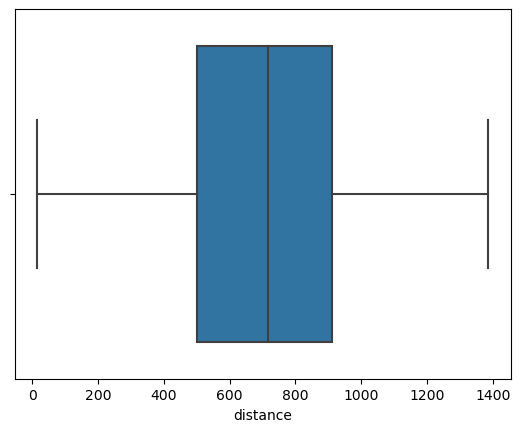

In [125]:
sns.boxplot(x=combined_df_final['distance'])

(array([105., 299.,  63.,  15.]),
 array([1.  , 1.75, 2.5 , 3.25, 4.  ]),
 <BarContainer object of 4 artists>)

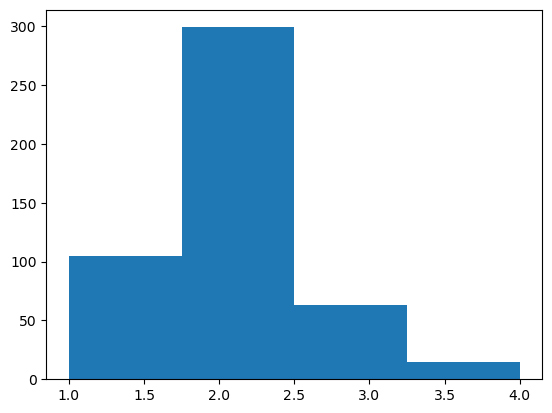

In [134]:
plt.hist(combined_df_final['price'], bins=4)

<Axes: xlabel='rating'>

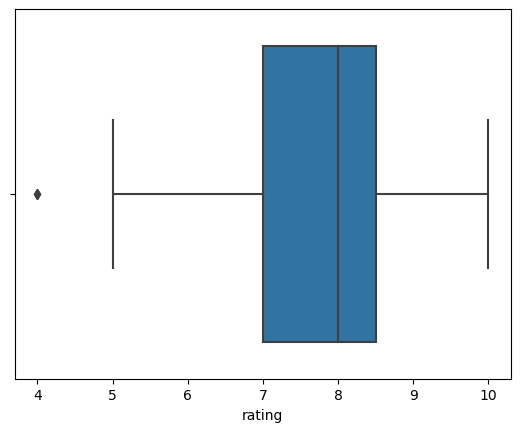

In [132]:
sns.boxplot(x=combined_df_final['rating'])

<Axes: xlabel='total_ratings'>

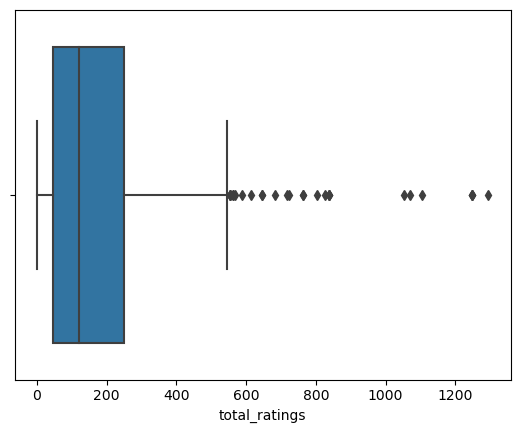

In [108]:
sns.boxplot(x=combined_df_final['total_ratings'])

In [238]:
#removing outliers if any
Q1 = combined_df_final.quantile(0.25, numeric_only=True)
Q3 = combined_df_final.quantile(0.75, numeric_only=True)
IQR = Q3 - Q1
print(IQR)

latitude           0.017040
longitude          0.031885
free_bikes         7.000000
distance         399.638349
price              0.000000
rating             0.800000
total_ratings    218.000000
dtype: float64


In [243]:
#The number of outliers varies on a case by case basis
non_outliers_max = combined_df_final[~((combined_df_final < (Q3 + (1.5 * IQR))).any(axis=1))]
non_outliers_min = combined_df_final[~((combined_df_final < (Q1 - (1.5 * IQR))).any(axis=1))]
no_outliers = pd.concat([non_outliers_min, non_outliers_max])
no_outliers.describe()

/tmp/ipykernel_4755/2788703957.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  non_outliers_max = combined_df_final[~((combined_df_final < (Q3 + (1.5 * IQR))).any(axis=1))]
/tmp/ipykernel_4755/2788703957.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  non_outliers_min = combined_df_final[~((combined_df_final < (Q1 - (1.5 * IQR))).any(axis=1))]


,latitude,longitude,free_bikes,distance,price,rating,total_ratings
count,4164.000000,4164.000000,4164.000000,4164.000000,3371.000000,4154.000000,4154.000000
mean,49.273971,-123.115884,7.965658,523.848069,2.239988,8.147689,218.318488
std,0.010829,0.024186,5.301754,258.952045,0.528379,0.667682,233.741583
min,49.243375,-123.177633,0.000000,0.000000,2.000000,6.800000,6.000000
25%,49.265213,-123.132585,4.000000,324.000000,2.000000,8.000000,54.250000
50%,49.275600,-123.117894,7.000000,513.447391,2.000000,8.000000,146.000000
75%,49.282758,-123.100792,11.000000,727.591297,2.000000,8.700000,289.000000
max,49.302577,-123.035969,29.000000,999.561524,4.000000,10.000000,2592.000000


# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

Look at the data before and after the join to validate your data.